<a href="https://colab.research.google.com/github/silveirafatup-maker/DIO/blob/main/reconhecimento_facial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Criando um sistema de reconhecimento facial do zero

## Descrição das Células do Notebook

Este notebook está estruturado em três células principais para configurar e executar o sistema de Detecção e Reconhecimento Facial:

---

### Célula 1: Configuração, Instalação e Downloads

-   **Função:** Prepara o ambiente de execução.
-   **Conteúdo:**
    1.  Instala as bibliotecas Python necessárias (`opencv-python`, `tensorflow`, etc.).
    2.  Define variáveis globais (`NOMES_CLASSES`, `TAMANHO_FACE_CLASSIFICACAO`).
    3.  Baixa os arquivos essenciais para o disco local:
        -   O classificador **Haar Cascade** (`haarcascade_frontalface_default.xml`).
        -   A **imagem de teste** fornecida pelo usuário, salva como `teste_faces_local.jpg` (para garantir a estabilidade contra erros de URL).
    4.  Inicializa os objetos `cv2.CascadeClassifier` e o modelo de simulação `Keras`.

### Célula 2: Funções Principais de Processamento (Pipeline)

-   **Função:** Contém a lógica central do sistema.
-   **Conteúdo:**
    1.  `detectar_faces(caminho_imagem)`: Carrega a imagem do disco local, converte para escala de cinza e aplica o `detector_faces_cv.detectMultiScale` para encontrar as coordenadas dos rostos.
    2.  `reconhecer_e_desenhar(imagem_entrada, coordenadas_faces)`: Processa cada face detectada, simula o reconhecimento (usando o modelo Keras e as classes predefinidas) e desenha os *bounding boxes* e rótulos na imagem.
    3.  `executar_sistema_deteccao_facial(caminho_imagem, titulo)`: Função que coordena as etapas de detecção e reconhecimento, e exibe o resultado final com a comparação lado a lado.

### Célula 3: Execução

-   **Função:** Inicia o processo de detecção.
-   **Conteúdo:**
    1.  Chama a função `executar_sistema_deteccao_facial()`, passando o caminho do arquivo local (`CAMINHO_IMAGEM_TESTE`) para iniciar o pipeline.

In [1]:
# Instala as bibliotecas
!pip install opencv-python tensorflow numpy matplotlib -q
# exibição correta de imagens no Colab
%matplotlib inline

Célula 1: Instalação, Configuração e Downloads

Esta célula garante que o ambiente esteja pronto e que os arquivos essenciais (haarcascade e a imagem de teste) sejam baixados.

In [3]:
# Célula 1: Instalação, Configuração e Downloads

# Importando Bibliotecas Essenciais
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import requests # Necessário para o método de URL
import os
import shutil


# Configuração do Ambiente
if tf.test.gpu_device_name():
    print('GPU detectada: {}'.format(tf.test.gpu_device_name()))
else:
    print("Nenhuma GPU detectada. Rodando em CPU.")

# Variáveis Globais
NOMES_CLASSES = ['Desconhecido', 'Alice', 'Bob', 'Charlie']
TAMANHO_FACE_CLASSIFICACAO = 160
CAMINHO_IMAGEM_TESTE = 'teste_faces_local.jpg' # arquivo de teste

print("\n--- Baixando Arquivos (Com Limpeza) ---")

try:
    # Limpa arquivos duplicados
    !rm haarcascade_frontalface_default.xml* || true
    !rm teste_faces_local.jpg || true

    # Baixa o modelo Haar Cascade
    !wget -q https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml

    # Baixa a imagem de detecção (Depositphotos)
    URL_DOWNLOAD_IMAGEM = "https://st2.depositphotos.com/3591429/7161/i/950/depositphotos_71611387-stock-photo-diversity-group-of-people-portrait.jpg"
    !wget -q {URL_DOWNLOAD_IMAGEM} -O {CAMINHO_IMAGEM_TESTE}

    # Verificando o tamanho do arquivo
    !ls -lh {CAMINHO_IMAGEM_TESTE}

    print(f"Arquivos de suporte e imagem de teste baixados com sucesso como: {CAMINHO_IMAGEM_TESTE}")
except Exception as e:
    print(f"AVISO: Falha ao tentar baixar os arquivos. Erro: {e}")
    print("Verifique a conexão ou carregue o arquivo manualmente.")

# Inicializa o modelo (simulado) e o detector Haar Cascade
def carregar_modelo_reconhecimento_facial():
    modelo = keras.Sequential([
        keras.Input(shape=(TAMANHO_FACE_CLASSIFICACAO, TAMANHO_FACE_CLASSIFICACAO, 3)),
        keras.layers.Conv2D(32, 3, activation='relu'),
        keras.layers.MaxPooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dense(len(NOMES_CLASSES), activation='softmax')
    ])
    return modelo

modelo_reconhecedor_facial = carregar_modelo_reconhecimento_facial()

detector_faces_cv = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

print("\nSetup inicial concluído.")


Nenhuma GPU detectada. Rodando em CPU.

--- Baixando Arquivos (Com Limpeza) ---
-rw-r--r-- 1 root root 125K Apr 29  2015 teste_faces_local.jpg
Arquivos de suporte e imagem de teste baixados com sucesso como: teste_faces_local.jpg

Setup inicial concluído.


Célula 2: Funções Principais de Processamento

In [4]:
# Célula 2: Funções Principais de Detecção e Pipeline

def detectar_faces(caminho_imagem):
    """Detecta faces na imagem lendo do arquivo local."""

    if detector_faces_cv.empty():
        print("ERRO de CONFIGURAÇÃO: Classificador Haar Cascade indisponível.")
        return None, []

    print(f"\n--- Carregando imagem de arquivo local: {caminho_imagem} ---")

    imagem = cv2.imread(caminho_imagem)

    if imagem is None or imagem.size == 0:
        print(f"ERRO DE CARREGAMENTO: Não foi possível carregar a imagem do arquivo: {caminho_imagem}.")
        return None, []

    # EXIBIÇÃO INTERMEDIÁRIA: Imagem Carregada
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB))
    plt.title('1. Imagem Carregada (Entrada Local)')
    plt.axis('off')
    plt.show()

    # Processamento e Detecção
    imagem_cinza = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)

    coordenadas_faces = detector_faces_cv.detectMultiScale(
        imagem_cinza,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30)
    )

    if len(coordenadas_faces) > 0:
        imagem_temp = imagem.copy()
        for (x, y, w, h) in coordenadas_faces:
            cv2.rectangle(imagem_temp, (x, y), (x + w, y + h), (0, 255, 255), 2)

        plt.figure(figsize=(6, 6))
        plt.imshow(cv2.cvtColor(imagem_temp, cv2.COLOR_BGR2RGB))
        plt.title(f'2. Detecção de {len(coordenadas_faces)} Faces')
        plt.axis('off')
        plt.show()

    return imagem, coordenadas_faces


# RECONHECIMENTO E DESENHO

def reconhecer_e_desenhar(imagem_entrada, coordenadas_faces):
    """Processa cada face detectada, reconhece usando Keras e desenha caixas."""

    imagem_saida = imagem_entrada.copy()

    for (x, y, w, h) in coordenadas_faces:

        face_cortada = imagem_saida[y:y+h, x:x+w]

        face_redimensionada = cv2.resize(face_cortada, (TAMANHO_FACE_CLASSIFICACAO, TAMANHO_FACE_CLASSIFICACAO))
        face_normalizada = face_redimensionada.astype("float32") / 255.0
        face_para_previsao = np.expand_dims(face_normalizada, axis=0)

        previsoes = modelo_reconhecedor_facial.predict(face_para_previsao, verbose=0)[0]
        indice_maximo = np.argmax(previsoes)
        confianca = previsoes[indice_maximo]

        if confianca > 0.8:
            nome = NOMES_CLASSES[indice_maximo]
            cor = (0, 255, 0)
        else:
            nome = "Desconhecido"
            cor = (0, 0, 255)

        cv2.rectangle(imagem_saida, (x, y), (x + w, y + h), cor, 2)

        rotulo = f"{nome}: {confianca:.2f}"
        cv2.putText(imagem_saida, rotulo, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, cor, 2)

    return imagem_saida


# Pipeline Principal de Execução

def executar_sistema_deteccao_facial(caminho_imagem, titulo="Reconhecimento Facial"):
    """Função principal que orquestra todo o processo e mostra os resultados."""

    imagem_detectada, coordenadas_faces = detectar_faces(caminho_imagem)

    if imagem_detectada is None:
        return

    print(f"\nFaces detectadas: {len(coordenadas_faces)}")

    if len(coordenadas_faces) == 0:
        print("Nenhuma face detectada para reconhecimento.")
        return

    imagem_depois = reconhecer_e_desenhar(imagem_detectada.copy(), coordenadas_faces)

    # Comparação Lado a Lado (Resultado)
    imagem_detectada_rgb = cv2.cvtColor(imagem_detectada, cv2.COLOR_BGR2RGB)
    imagem_depois_rgb = cv2.cvtColor(imagem_depois, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(15, 8))

    plt.subplot(1, 2, 1)
    plt.imshow(imagem_detectada_rgb)
    plt.title('Imagem Original (para comparação)')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(imagem_depois_rgb)
    plt.title('Resultado Final: Reconhecimento Seletivo')
    plt.axis('off')

    plt.suptitle(titulo, fontsize=16)
    plt.show()


Célula 3: Execução


--- Carregando imagem de arquivo local: teste_faces_local.jpg ---


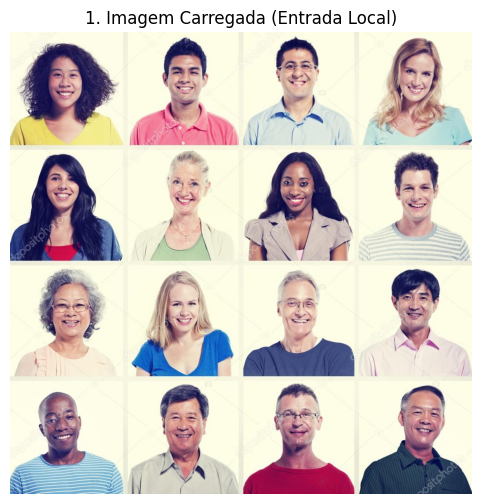

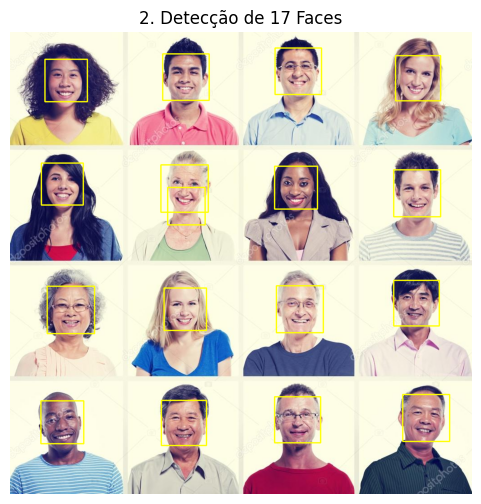


Faces detectadas: 17


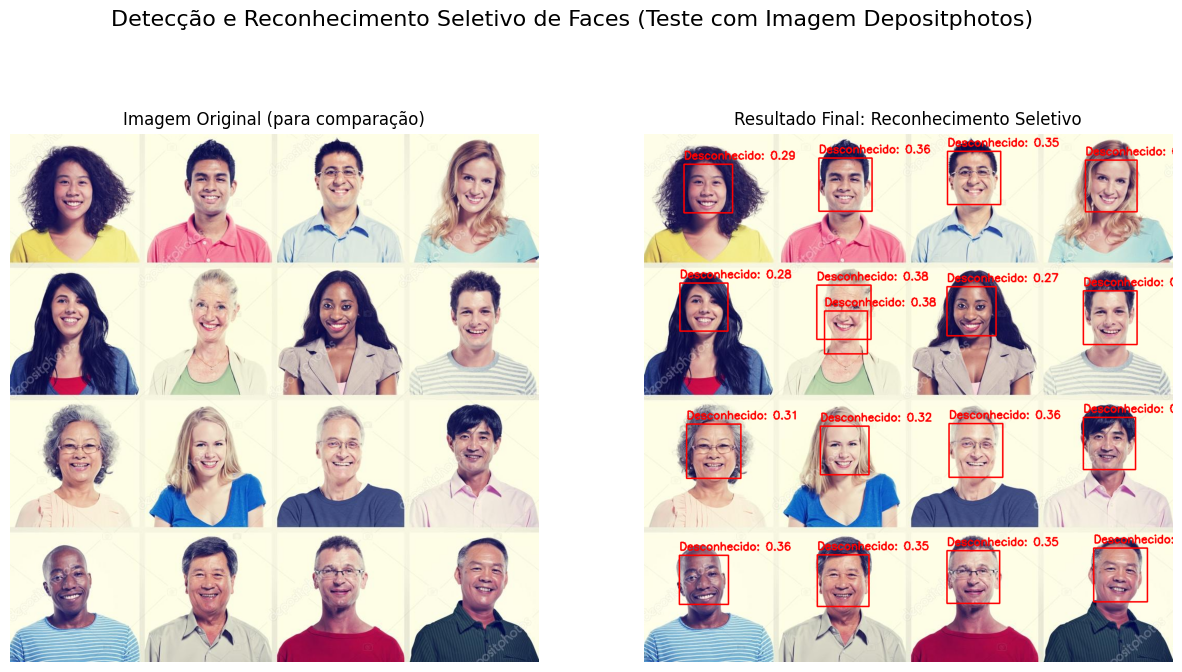

In [5]:
# Célula 3: Execução do Sistema

executar_sistema_deteccao_facial(
    CAMINHO_IMAGEM_TESTE,
    titulo="Detecção e Reconhecimento Seletivo de Faces (Teste com Imagem Depositphotos)"
)